# Machine Learning Models – Train & Evaluate

**EEG Stress Level Classification**

Models: Random Forest, SVM, KNN, Gradient Boosting, Logistic Regression  
Target: `stress_level` (0=Natural, 1=Low, 2=Mid, 3=High)

## Part 1: Import Required Libraries

In [3]:
import os, json, warnings
import numpy as np
import pandas as pd
import joblib
from pathlib import Path

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## Part 2: Configuration & Constants

In [4]:
# Paths
ROOT = Path(".")
MODEL_DIR = ROOT / "models"
MODEL_DIR.mkdir(exist_ok=True)
STATIC_DIR = ROOT / "static"
STATIC_DIR.mkdir(exist_ok=True)

# Class names
STRESS_NAMES = ["natural", "lowlevel", "midlevel", "highlevel"]

print(f"✓ Model directory: {MODEL_DIR.resolve()}")
print(f"✓ Static directory: {STATIC_DIR.resolve()}")

✓ Model directory: /home/noman/MyFiles/AI/Research Paper/raw_data/models
✓ Static directory: /home/noman/MyFiles/AI/Research Paper/raw_data/static


## Part 3: Load & Explore Dataset

In [5]:
# Load processed dataset
df = pd.read_csv(ROOT / "processed_dataset.csv")

# Separate features and target
exclude = {"task", "stress_level", "stress_label", "participant"}
feature_cols = [c for c in df.columns if c not in exclude]
X = df[feature_cols].values
y = df["stress_level"].values

print(f"Dataset shape: {df.shape}")
print(f"Features: {len(feature_cols)}")
print(f"\nStress distribution:")
print(df["stress_label"].value_counts())
print(f"\nTask distribution:")
print(df["task"].value_counts())
df.head()

Dataset shape: (120, 81)
Features: 77

Stress distribution:
stress_label
natural      30
lowlevel     30
midlevel     30
highlevel    30
Name: count, dtype: int64

Task distribution:
task
Arithmetic    60
Stroop        60
Name: count, dtype: int64


,EEG_TP9_mean,EEG_TP9_std,EEG_TP9_min,EEG_TP9_max,EEG_TP9_median,EEG_TP9_skew,EEG_TP9_kurtosis,EEG_AF7_mean,EEG_AF7_std,EEG_AF7_min,...,ACC_Z_std,ACC_Z_min,ACC_Z_max,ACC_Z_median,ACC_Z_skew,ACC_Z_kurtosis,task,stress_level,stress_label,participant
0,34495.973774,425.248055,0.000000,35121.161952,34440.886610,-24.525585,1996.739863,33218.681656,447.659044,0.000000,...,0.004106,0.958,0.986,0.974,-0.188457,0.045613,Arithmetic,0,natural,1
1,4784.667376,1247.884626,1943.372422,6799.132442,5116.716637,-0.406030,-1.054502,11161.100071,1432.710628,7548.832303,...,0.010619,0.436,0.984,0.966,-35.965067,1665.681932,Arithmetic,0,natural,2
2,10416.587985,1629.202128,8633.987145,14319.734492,9555.974252,0.980290,-0.385080,8156.463594,1368.831166,6743.543654,...,0.010865,0.482,0.988,0.972,-31.543519,1291.021715,Arithmetic,0,natural,3
3,3227.577829,129.636637,0.000000,3703.818167,3205.083693,-0.177797,23.316549,8109.127702,114.684066,0.000000,...,0.003904,0.962,0.986,0.976,-0.205180,0.021682,Arithmetic,0,natural,4
4,32540.355822,917.439166,0.000000,34052.502698,32608.580006,-3.257783,54.516221,16250.237732,647.384306,0.000000,...,0.012426,0.000,0.990,0.972,-15.170497,1131.139968,Arithmetic,0,natural,5


## Part 4: Feature Scaling & Train/Test Split

In [6]:
# StandardScaler for feature normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save scaler & feature columns for later use in prediction
joblib.dump(scaler, MODEL_DIR / "scaler.pkl")
joblib.dump(feature_cols, MODEL_DIR / "feature_cols.pkl")

# Train/Test split (80/20, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set:     {X_test.shape[0]} samples")
print(f"Features:     {X_train.shape[1]}")

Training set: 96 samples
Test set:     24 samples
Features:     77


## Part 5: Define ML Models

In [7]:
# Define all ML models
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=200, max_depth=15, random_state=42
    ),
    "SVM": SVC(kernel="rbf", C=10, gamma="scale", probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5, weights="distance"),
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42
    ),
    "LogisticRegression": LogisticRegression(
        max_iter=2000, C=1.0, random_state=42
    ),
}

print(f"✓ Defined {len(models)} models:")
for name in models:
    print(f"  • {name}")

✓ Defined 5 models:
  • RandomForest
  • SVM
  • KNN
  • GradientBoosting
  • LogisticRegression


## Part 6: Train & Evaluate All Models

Cross-validation (5-fold stratified) + test set evaluation for each model.  
Metrics: Accuracy, Precision, Recall, F1-Score.

In [8]:
results = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name} …")
    print(f"{'='*50}")

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")
    print(f"  CV accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Fit on full training set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    results[name] = {
        "accuracy": round(acc, 4),
        "precision": round(prec, 4),
        "recall": round(rec, 4),
        "f1_score": round(f1, 4),
        "cv_mean": round(cv_scores.mean(), 4),
        "cv_std": round(cv_scores.std(), 4),
    }

    print(f"  Test accuracy:  {acc:.4f}")
    print(f"  Precision:      {prec:.4f}")
    print(f"  Recall:         {rec:.4f}")
    print(f"  F1-score:       {f1:.4f}")
    print(f"\n  Classification Report:")
    print(classification_report(y_test, y_pred, target_names=STRESS_NAMES, zero_division=0))

    # Save model
    joblib.dump(model, MODEL_DIR / f"ml_{name}.pkl")

print("\n✓ All models trained and saved!")


Training RandomForest …
  CV accuracy: 0.3647 ± 0.1202
  Test accuracy:  0.3333
  Precision:      0.3500
  Recall:         0.3333
  F1-score:       0.3409

  Classification Report:
              precision    recall  f1-score   support

     natural       1.00      1.00      1.00         6
    lowlevel       0.20      0.17      0.18         6
    midlevel       0.00      0.00      0.00         6
   highlevel       0.20      0.17      0.18         6

    accuracy                           0.33        24
   macro avg       0.35      0.33      0.34        24
weighted avg       0.35      0.33      0.34        24


Training SVM …
  CV accuracy: 0.3142 ± 0.1127
  Test accuracy:  0.2917
  Precision:      0.3727
  Recall:         0.2917
  F1-score:       0.3203

  Classification Report:
              precision    recall  f1-score   support

     natural       1.00      0.67      0.80         6
    lowlevel       0.00      0.00      0.00         6
    midlevel       0.09      0.17      0.12    

## Part 7: Confusion Matrices

Visualize confusion matrix for each trained model.

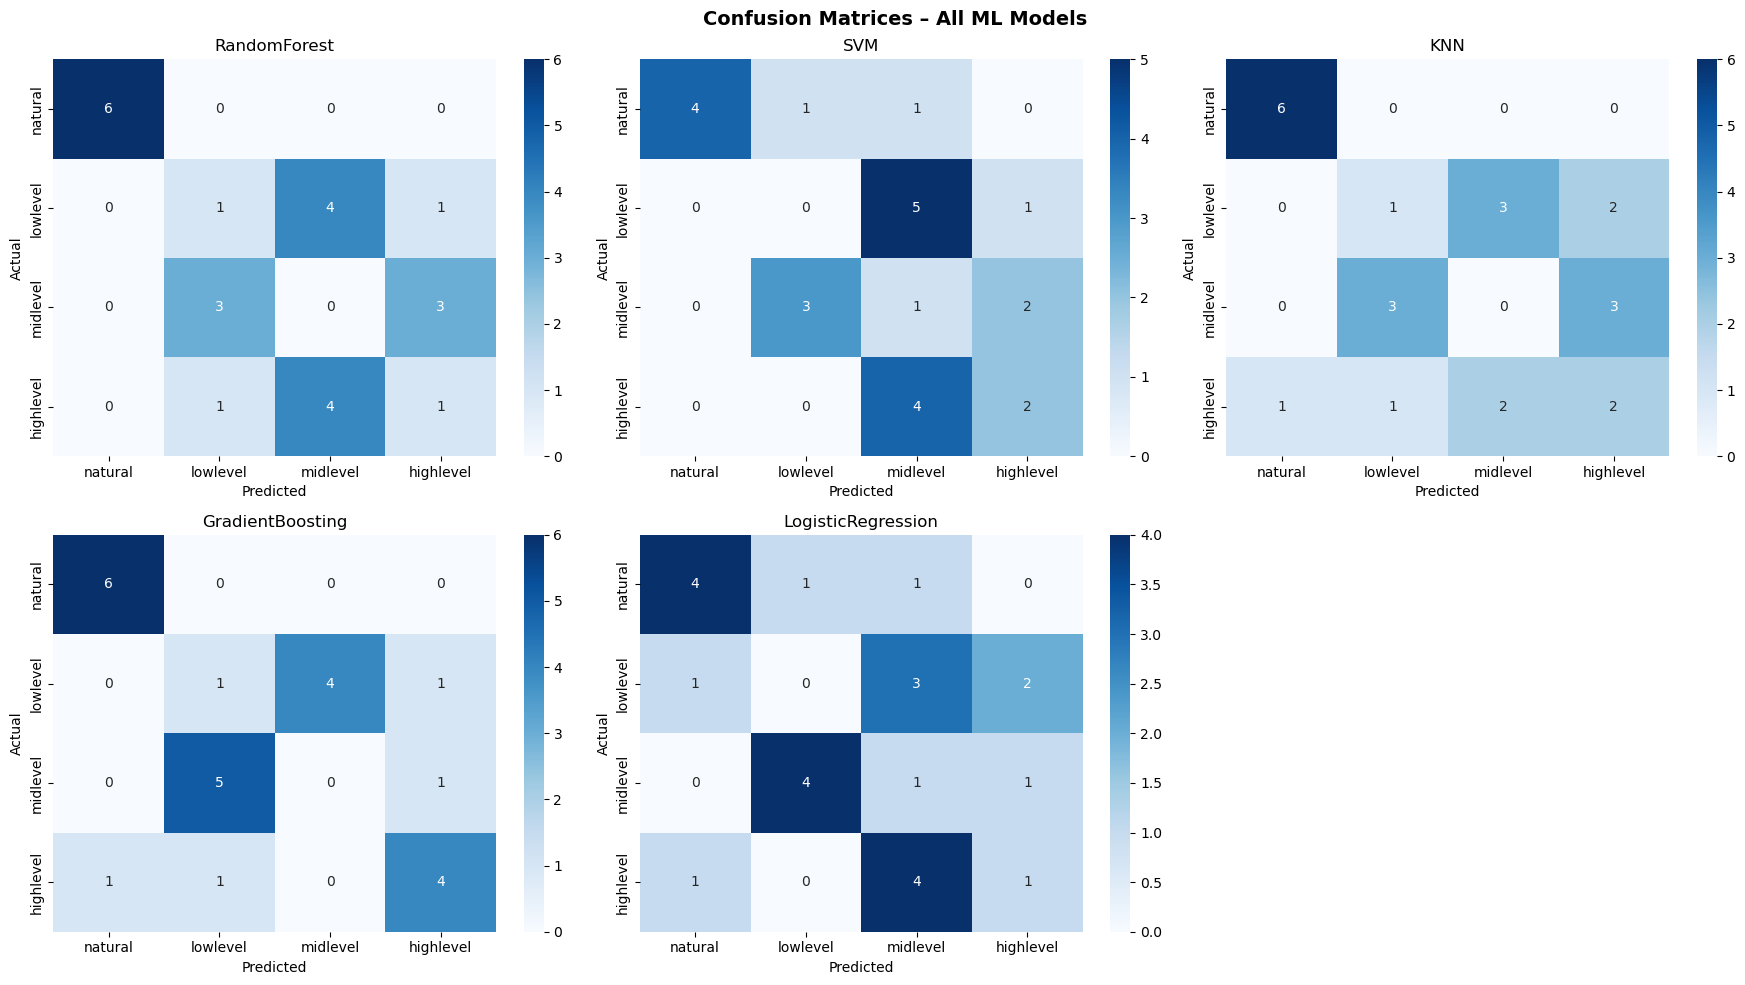

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=STRESS_NAMES, yticklabels=STRESS_NAMES, ax=axes[idx])
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")
    axes[idx].set_title(f"{name}")
    
    # Also save individual confusion matrix
    fig_single, ax_single = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=STRESS_NAMES, yticklabels=STRESS_NAMES, ax=ax_single)
    ax_single.set_xlabel("Predicted")
    ax_single.set_ylabel("Actual")
    ax_single.set_title(f"{name} – Confusion Matrix")
    fig_single.tight_layout()
    fig_single.savefig(STATIC_DIR / f"cm_{name}.png", dpi=100)
    plt.close(fig_single)

# Hide unused subplot
axes[-1].set_visible(False)

fig.suptitle("Confusion Matrices – All ML Models", fontsize=14, fontweight="bold")
fig.tight_layout()
plt.show()

## Part 8: Model Comparison Chart

Bar chart comparing Accuracy, Precision, Recall, and F1-Score across all models.

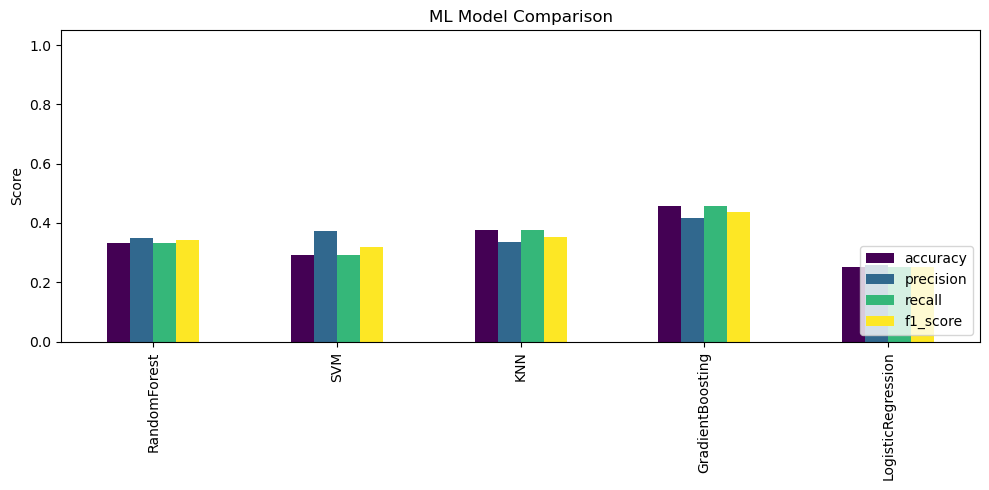


Results Table:


,accuracy,precision,recall,f1_score,cv_mean,cv_std
RandomForest,0.3333,0.3500,0.3333,0.3409,0.3647,0.1202
SVM,0.2917,0.3727,0.2917,0.3203,0.3142,0.1127
KNN,0.3750,0.3357,0.3750,0.3531,0.2611,0.0830
GradientBoosting,0.4583,0.4167,0.4583,0.4359,0.4163,0.1273
LogisticRegression,0.2500,0.2569,0.2500,0.2500,0.3437,0.0781


In [10]:
res_df = pd.DataFrame(results).T

fig, ax = plt.subplots(figsize=(10, 5))
res_df[["accuracy", "precision", "recall", "f1_score"]].plot(
    kind="bar", ax=ax, colormap="viridis"
)
ax.set_ylabel("Score")
ax.set_title("ML Model Comparison")
ax.set_ylim(0, 1.05)
ax.legend(loc="lower right")
fig.tight_layout()
fig.savefig(STATIC_DIR / "ml_comparison.png", dpi=100)
plt.show()

print("\nResults Table:")
display(res_df)

## Part 9: Save Results

Save all results as JSON and print final summary.

In [11]:
# Save results JSON
with open(ROOT / "ml_results.json", "w") as f:
    json.dump(results, f, indent=2)

# Final summary
print("=" * 50)
print("ML Training Complete!")
print("=" * 50)
for name, r in results.items():
    print(f"  {name:25s} → acc={r['accuracy']:.4f}  f1={r['f1_score']:.4f}")

print(f"\n✓ Results saved to ml_results.json")
print(f"✓ Models saved to {MODEL_DIR}/")
print(f"✓ Charts saved to {STATIC_DIR}/")

ML Training Complete!
  RandomForest              → acc=0.3333  f1=0.3409
  SVM                       → acc=0.2917  f1=0.3203
  KNN                       → acc=0.3750  f1=0.3531
  GradientBoosting          → acc=0.4583  f1=0.4359
  LogisticRegression        → acc=0.2500  f1=0.2500

✓ Results saved to ml_results.json
✓ Models saved to models/
✓ Charts saved to static/
